In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
current_dir = "/kaggle/input/isic-2024-challenge"

# List all files in the current directory (excluding subdirectories)
files_in_dir = [f for f in os.listdir(current_dir)]
for file in files_in_dir:
    print(file)

    
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

sample_submission.csv
train-metadata.csv
test-metadata.csv
test-image.hdf5
train-image
train-image.hdf5


## Libraries and dependencies

In [2]:
import numpy as np 
import pandas as pd 
import os 
import h5py
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
import plotly.express as px
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,KNNImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.feature_extraction import FeatureHasher
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression,SGDClassifier,BayesianRidge
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.combine import *
from imblearn.under_sampling import *
from imblearn.over_sampling import *
from imblearn.pipeline import Pipeline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import catboost as cb
from sklearn.ensemble import VotingClassifier,StackingClassifier

In [3]:
# Deep learning keras libraries
import keras
print(keras.__version__)
import tensorflow as tf

3.4.1


## Data loading


In [4]:
current_dir = "/kaggle/input/isic-2024-challenge"
sample_submission = pd.read_csv(os.path.join(current_dir,'sample_submission.csv'))
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   isic_id  3 non-null      object 
 1   target   3 non-null      float64
dtypes: float64(1), object(1)
memory usage: 176.0+ bytes


In [5]:
sample_submission.head()

,isic_id,target
0,ISIC_0015657,0.3
1,ISIC_0015729,0.3
2,ISIC_0015740,0.3


In [6]:
train_metadata = pd.read_csv(os.path.join(current_dir,'train-metadata.csv'),low_memory=False)
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   401059 non-nul

In [7]:
train_metadata.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [8]:
test_metadata = pd.read_csv(os.path.join(current_dir,'test-metadata.csv'),low_memory=False)
test_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   isic_id                      3 non-null      object 
 1   patient_id                   3 non-null      object 
 2   age_approx                   3 non-null      float64
 3   sex                          3 non-null      object 
 4   anatom_site_general          3 non-null      object 
 5   clin_size_long_diam_mm       3 non-null      float64
 6   image_type                   3 non-null      object 
 7   tbp_tile_type                3 non-null      object 
 8   tbp_lv_A                     3 non-null      float64
 9   tbp_lv_Aext                  3 non-null      float64
 10  tbp_lv_B                     3 non-null      float64
 11  tbp_lv_Bext                  3 non-null      float64
 12  tbp_lv_C                     3 non-null      float64
 13  tbp_lv_Cext             

In [9]:
test_metadata.head()

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


#### Load Image Byte String

In this competition, images are provided as byte strings. The following code snippet demonstrates how to load these images into memory. One might wonder why the provided jpeg images aren't being used in the /train-image folder for training. This is because testing images are not provided as JPEG images; instead, they are provided as byte strings. Why use byte strings? They occupy significantly less memory compared to np.array representations.


In [10]:
# image sample visualization
training_validation_hdf5 = h5py.File(f"{current_dir}/train-image.hdf5", 'r')
testing_hdf5 = h5py.File(f"{current_dir}/test-image.hdf5", 'r')

Image ISIC_1295998:
Shape:(129, 129, 3)


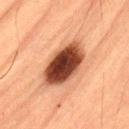

Image ISIC_7126364:
Shape:(123, 123, 3)


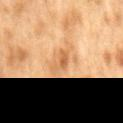

In [11]:
# sample randomly two images from the train dataset
img_sample = train_metadata['isic_id'].sample(n=2).to_list()

# load the image from byte arrays, 
byte_str = [training_validation_hdf5[isic_id][()] for isic_id in img_sample]

# convert byte str to numpy array
img_arr = [np.frombuffer(byte, np.uint8) for byte in byte_str]

# convert cv2 image
img_cv2 = [cv2.imdecode(nparr, cv2.IMREAD_COLOR) for nparr in img_arr] 
for ind,val in enumerate(img_cv2):
    print(f"Image {img_sample[ind]}:")
    print(f"Shape:{val.shape}")
    cv2_imshow(val)

Image ISIC_0015657:
Shape:(141, 141, 3)


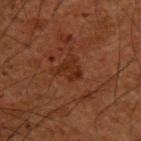

Image ISIC_0015740:
Shape:(119, 119, 3)


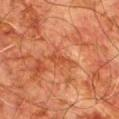

Image ISIC_0015729:
Shape:(125, 125, 3)


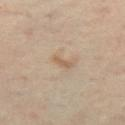

In [12]:
# sample randomly two images from the train dataset
img_sample = test_metadata['isic_id'].sample(n=3).to_list()

# load the image from byte arrays, 
byte_str = [testing_hdf5[isic_id][()] for isic_id in img_sample]

# convert byte str to numpy array
img_arr = [np.frombuffer(byte, np.uint8) for byte in byte_str]

# convert cv2 image
img_cv2 = [cv2.imdecode(nparr, cv2.IMREAD_COLOR) for nparr in img_arr] 
for ind,val in enumerate(img_cv2):
    print(f"Image {img_sample[ind]}:")
    print(f"Shape:{val.shape}")
    cv2_imshow(val)

## Preprocessing

In [13]:
class DataPreprocessor:
    def __init__(self):
        self.preprocessor = None
        self.train_columns = None

    def fit_transform(self, df):
        """Preprocess training data and store transformations."""
        df = df.copy()
        df = self._drop_irrelevant_columns(df)
        df = self._drop_train_only_columns(df)
        categorical_cols, numerical_cols = self._identify_column_types(df)
        
        # Define preprocessing pipelines
        numerical_pipeline = Pipeline([
            # ("imputer", SimpleImputer(strategy="median")),
            ("imputer", KNNImputer()),
            ("scaler", StandardScaler())
        ])
        
        categorical_pipeline = Pipeline([
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ])
        
        self.preprocessor = ColumnTransformer([
            ("num", numerical_pipeline, numerical_cols),
            ("cat", categorical_pipeline, categorical_cols)
        ])
        
        transformed_data = self.preprocessor.fit_transform(df)
        
        cat_feature_names = self.preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(categorical_cols)
        all_columns = numerical_cols + list(cat_feature_names)
        
        df_processed = pd.DataFrame(transformed_data, columns=all_columns)
        df_processed["isic_id"] = df["isic_id"].values
        df_processed["target"] = df["target"].values
        
        self.train_columns = df_processed.columns  # Store train columns
        return df_processed

    def transform(self, df):
        """Preprocess test data using stored transformations from training."""
        df = df.copy()
        df = self._drop_irrelevant_columns(df)
        
        transformed_data = self.preprocessor.transform(df)
        cat_feature_names = self.preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out()
        all_columns = self.train_columns[:-2]  # Exclude 'isic_id' and 'target'
        
        df_processed = pd.DataFrame(transformed_data, columns=all_columns)
        df_processed["isic_id"] = df["isic_id"].values
        # df_processed["target"] = df["target"].values
        
        # Align test dataset with train columns
        df_processed = self._align_train_test_columns(df_processed)
        return df_processed

    def _drop_irrelevant_columns(self, df):
        """Remove unnecessary columns."""
        return df.drop(columns=['patient_id','image_type', 'tbp_tile_type', 'attribution', 'copyright_license'], errors="ignore")

    def _drop_train_only_columns(self,df):
        """Remove columns that are present only in the train set and not in the test set"""
        drop_train_only_columns = [
            'lesion_id', 'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
            'mel_mitotic_index', 'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence'
            ]
        return df.drop(columns=drop_train_only_columns,errors='ignore')
        

    def _identify_column_types(self, df):
        """Identify categorical and numerical columns, excluding 'isic_id' and 'target'."""
        categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
        numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        categorical_cols = [col for col in categorical_cols if col != "isic_id"]
        numerical_cols = [col for col in numerical_cols if col != "target"]
        return categorical_cols, numerical_cols
    
    def _align_train_test_columns(self, df):
        """Ensure test data has the same columns as train data."""
        train_cols = list(self.train_columns)
        train_cols.remove('target')
        missing_cols = set(train_cols) - set(df.columns)
        for col in missing_cols:
            df[col] = 0
        return df[train_cols]


In [14]:
train_metadata = pd.read_csv(os.path.join(current_dir, 'train-metadata.csv'), low_memory=False)
test_metadata = pd.read_csv(os.path.join(current_dir, 'test-metadata.csv'), low_memory=False)

In [15]:
data_object = DataPreprocessor()
train_metadata_processed = data_object.fit_transform(train_metadata)
test_metadata_processed = data_object.transform(test_metadata)

In [16]:
X_train = train_metadata_processed.drop(columns=['target'])
y_train = train_metadata_processed['target']
X_test = test_metadata_processed.copy()


## handling class imbalance

In [17]:
def resampler_data(X, Y):
    
    # Apply undersampling only on numerical data
    resampler = RandomUnderSampler(sampling_strategy=0.01,)
    X_resampled, Y_resampled = resampler.fit_resample(X,Y)
    
    # now apply over sampling for the minorit class
    resampler = RandomOverSampler(sampling_strategy=0.3)
    X_resampled, Y_resampled = resampler.fit_resample(X_resampled, Y_resampled)

    print("X_final shape;",X_resampled.shape)
    print("Y_final shape:",Y_resampled.shape)
    
    return X_resampled, Y_resampled

In [18]:
X_train_final, y_train_final = resampler_data(X_train, y_train)

X_final shape; (51090, 73)
Y_final shape: (51090,)


## metadata only model for submission checking

In [19]:
# Compute class weights
class_weights = y_train_final.value_counts(normalize=True).to_dict()
class_weights = {k: 1/v for k, v in class_weights.items()}
print(class_weights)

{0: 1.2999999999999998, 1: 4.333333333333333}


In [20]:
# Convert data to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_final.drop(columns=['isic_id'],axis=1), label=y_train_final, weight=[class_weights[y] for y in y_train_final])
# dval = xgb.DMatrix(X_val.drop(columns=['isic_id'],axis=1), label=y_val)

In [21]:
# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': class_weights[1] / class_weights[0],
    'max_depth': 10,
    'eta': 0.01,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'random_state': 63
}

# # Train the XGBoost classifier with cross-validation
# cv_results = xgb.cv(
#     params,
#     dtrain,
#     num_boost_round=10000,
#     nfold=5,
#     early_stopping_rounds=10,
#     metrics='logloss',
#     as_pandas=True,
#     seed=42
# )

In [22]:
# # View the train set results
# print("Cross-validation results:")
# print(cv_results)

In [23]:
# num_boost_rounds = cv_results['test-logloss-mean'].idxmin()
# xgb_model = xgb.train(params, dtrain, num_boost_round=num_boost_rounds)
# print(num_boost_rounds)

In [24]:
# light gbm model
lgb_matrix = lgb.Dataset(X_train_final.drop(columns=['isic_id'],axis=1), label=y_train_final, weight=[class_weights[y] for y in y_train_final])

lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'eta': 0.01,
    'num_iterations':10000,
    'num_leaves':63,
    'random_state': 42,
    'verbose':-1
}

In [25]:
# lgb_model = lgb.train(lgb_params, lgb_matrix, num_boost_round=1000)

In [26]:
# # CatBoost model
# cb_model = cb.CatBoostClassifier(iterations=10000, depth=6, learning_rate=0.01, loss_function='Logloss', random_seed=42)
# cb_model.fit(X_train_final.drop(columns=['isic_id'],axis=1), y_train_final, sample_weight=[class_weights[y] for y in y_train_final], verbose=0)


In [27]:
# Predict class probabilities on the test data
dtest = xgb.DMatrix(X_test.drop(columns=['isic_id'],axis=1))
# y_test_pred_proba = model.predict(dtest)
# # Output the predicted probabilities
# print(y_test_pred_proba)

In [28]:
xgb_pred = lambda X: xgb_model.predict(dtest)
lgb_pred = lambda X: lgb_model.predict(X_test.drop(columns=['isic_id'],axis=1))
cb_pred = lambda X: cb_model.predict_proba(X_test.drop(columns=['isic_id'],axis=1))[:, 1]

In [29]:
# xgb_pred(dtest)

In [30]:
# lgb_pred(X_test)

In [31]:
# cb_pred(X_test)

In [32]:
# final_pred = np.mean([xgb_pred(dtest),lgb_pred(X_test),cb_pred(X_test)],axis=0)
# final_pred

In [33]:
# Create Stacking Model
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb.XGBClassifier(**params)),
        ('lgb', lgb.LGBMClassifier(**lgb_params)),
        ('cb', cb.CatBoostClassifier(iterations=10000,depth=10, learning_rate=0.01, loss_function='Logloss', random_seed=42))
    ],
    final_estimator=LogisticRegression(),
    stack_method='predict_proba',
    verbose=2,
    n_jobs=-1
)

In [34]:
stacking_model.fit(X_train_final.drop(columns=['isic_id'],axis=1), y_train_final)
final_pred = stacking_model.predict_proba(X_test.drop(columns=['isic_id'],axis=1))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [35]:
train_pred = stacking_model.predict_proba(X_train_final.drop(columns=['isic_id'],axis=1))

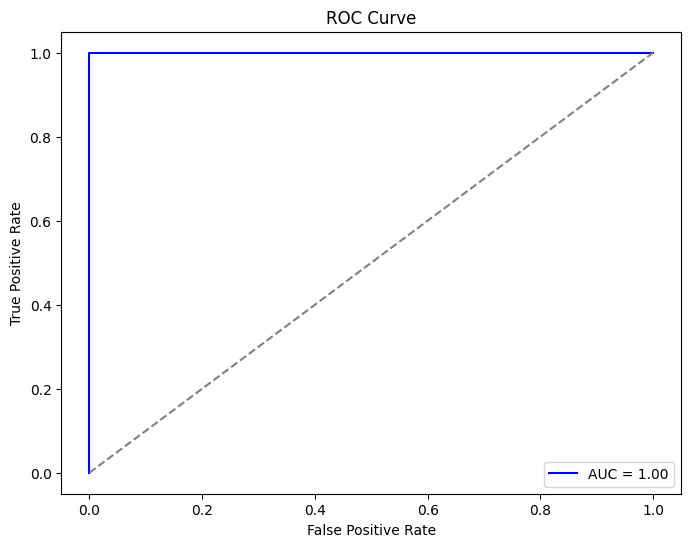

In [36]:
fpr, tpr, _ = roc_curve(y_train_final, train_pred[:,1])
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random model line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [37]:
print(roc_auc)

1.0


In [38]:
final_pred = final_pred[:,1]
final_pred

array([1.02281468e-05, 1.00112889e-05, 1.02180441e-05])

In [39]:
sub_df = pd.concat([X_test['isic_id'],pd.Series(final_pred)],axis=1)
sub_df.head()

,isic_id,0
0,ISIC_0015657,0.00001
1,ISIC_0015729,0.00001
2,ISIC_0015740,0.00001


In [40]:
sub_df.to_csv('submission.csv', index=False)